In [6]:
from transformers import ViTModel, ViTConfig, ViTFeatureExtractor
from SketchKeras.sketch_model import SketchKeras
import SketchKeras.sketchkeras as SK
import torch
from torchvision import transforms as T
import numpy as np
from PIL import Image
import cv2
from matplotlib import pyplot as plt

# Initializing a ViT vit-base-patch16-224 style configuration
configuration = ViTConfig()

# Initializing a model from the vit-base-patch16-224 style configuration
model = ViTModel(configuration)

# Accessing the model configuration
configuration = model.config

In [7]:
SKETCH_PATH = 'SketchKeras/model.pth'
sketchKeras = SketchKeras()
sketchKeras.load_state_dict(torch.load(SKETCH_PATH))
sketchKeras.to(model.device)

SketchKeras(
  (downblock_1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (2): BatchNorm2d(32, eps=0.001, momentum=0, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (downblock_2): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (2): BatchNorm2d(64, eps=0.001, momentum=0, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): BatchNorm2d(64, eps=0.001, momentum=0, affine=True, track_running_stats=True)
    (7): ReLU()
  )
  (downblock_3): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (2): BatchNorm2d(128, eps=0.001, momentum=0, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(128, 128, kernel_size=(3, 3), st

In [8]:
def sketch(image,patch_size=16,stride=4,theshold=253):
    img_shape = image.shape

    image = SK.load_image(image)

    image = sketchKeras(image.to(model.device))
    image = image.cpu().detach().numpy()
    
    sketch_image = SK.postprocess(image[0])
    sketch_image = T.ToPILImage()(sketch_image)
    sketch_image = T.Resize(size=(img_shape[0],img_shape[1]))(sketch_image)
    sketch_image= np.array(sketch_image)
    # print(sketch_image)
    sketch_image = np.where(sketch_image > theshold, 255, 0).astype(np.uint8)
    # plt.imshow(sketch_image,cmap='gray')
    return sketch_image

    # plt.show()
    # dataloader , images_char_width, images_char_height ,original_size= P.preprocess_image(sketch_image,patch_size,stride)
    # predictions = P.predict(model, dataloader)
    
    # text = P.postprocess(predictions, images_char_width, images_char_height, inv_chardict)
    
    # text_image = TextToImage(text)
    # text_image = T.ToPILImage()(text_image)
    # text_image = T.Resize(original_size)(text_image)


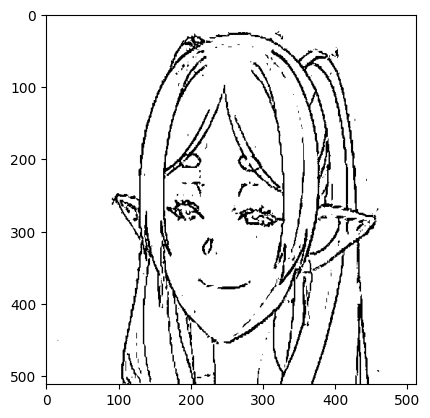

In [9]:
image = np.array(Image.open("images.jpeg").convert('RGB').resize((512,512)))

sketch = sketch(image)

plt.imshow(sketch,cmap='gray')

In [10]:
sketches = np.broadcast_to(sketch, (sketch.shape[0],sketch.shape[0],1)).copy()

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

inputs = feature_extractor(images=sketch, return_tensors="pt")

outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (512,512)  and requested shape (512,512,1)